In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import model
import datasets

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Make sure to use the GPU. The following line is just a check to see if GPU is availables
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# load your dataset and dataloader
# feel free to change header of bird_dataset class
# root = 'path to images/'
root = 'birds_dataset/'
train_dataset = datasets.bird_dataset(root,'train_list.txt')
test_dataset = datasets.bird_dataset(root,'test_list.txt')
val_dataset_1 = datasets.bird_dataset(root,'val_list1.txt')
val_dataset_2 = datasets.bird_dataset(root,'val_list2.txt')

# Fill in optional arguments to the dataloader as you need it

train_dataloader = DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=4,
                                         shuffle=False, num_workers=2)

val_dataset_1_dataloader = DataLoader(val_dataset_1, batch_size=1,
                                         shuffle=False, num_workers=2)
val_dataset_2_dataloader = DataLoader(val_dataset_2, batch_size=1,
                                         shuffle=False, num_workers=2)

In [4]:
#create validation set?
# train_ds, valid_ds = torch.utils.data.random_split(train_dataloader.dataset, (len(train_dataset)*0.75, len(train_dataset)*0.25))
# # print(len(train_dataloader.dataset))

In [5]:
# for i in range(len(train_dataset)):
#     sample = train_dataset[i]

#     print(i, sample['image'].shape, sample['classification'])

#     if i == 3:
#         break
# # print(train_dataset[1])

In [6]:
# Create NN model object
nn_model = model.baseline_Net(classes = 20)
nn_model.to(device)


baseline_Net(
  (b1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (b2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (b3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (b4): Sequential(
    (0): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Sequential(
    (0): Lin

In [7]:
# Create loss functions, optimizers
# For baseline model use this
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-4)
# Initialize weights

In [8]:
# print(train_dataloader.dataset[1])

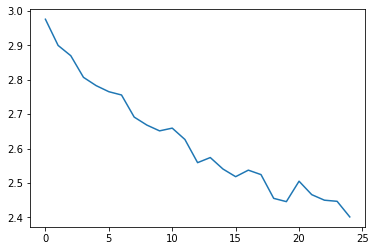

In [9]:
# train your model
# For each epoch iterate over your dataloaders/datasets, pass it to your NN model, get output, calculate loss and
# backpropagate using optimizer
num_epochs = 25
loss_results = []
# for iteration in range(num_epochs):
#     nn_model(train_dataloader)

for epoch in range(num_epochs):
    running_loss = 0.0
    counter = 0

    for i, data in enumerate(train_dataloader, 0):
        counter+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = nn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()


    loss_results.append(running_loss/counter)


epochs = [i for i in range(len(loss_results))]

plt.plot(epochs, loss_results)
plt.show()
# print(len(loss_results))

In [10]:
# Save your model/best model

In [11]:
total = 0
correct = 0
with torch.no_grad():
    nn_model.eval()
    for data in test_dataloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = nn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 23 %
